# Time Series Analysis - Assignment 12

## Data and Package Import

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('data/impurity_dataset-training.xlsx')

## 1. ARIMA  
In this assignment, we will construct an ARIMA model of the Dow dataset.

**Compute the moving average of the Dow dataset with a window size of 24 hours.**  

Plot the result.

In [3]:
dow_df = df[['Date', 'y:Impurity']]
dow_df.loc[:,'Date'] = pd.to_datetime(dow_df['Date'])
dow_df = dow_df.set_index('Date')

/Users/SihoonChoi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


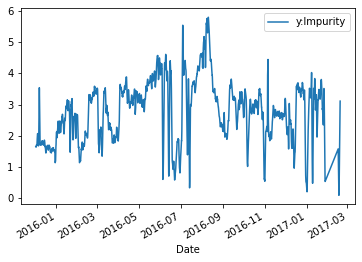

In [4]:
window = 24

rolling_df = dow_df.rolling(window)
moving_avg = rolling_df.mean()
moving_avg.plot();

**Split the `y:Impurity` data (not the smoothed version) into a training set and a test set.**

The first 75% of the data should be the training set and you will use a forecast to predict the next 25%, so you should not use random selection.

In [5]:
hours = dow_df.shape[0]

train_ratio = 0.75
N_train = int(train_ratio*hours)
N_test = hours - N_train

past = dow_df[:N_train]
future = dow_df[-N_test:]

**Determine `d` of the ARIMA model.**

Check the probability that the data is stationary after differencing using the augmented Dicky-Fuller test.

In [6]:
from statsmodels.tsa.stattools import adfuller

diff = dow_df - dow_df.shift(1)
diff = diff[1:]

p_val = adfuller(diff)[1]
print("Probability the data is stationary after 1 difference: {}".format(1 - p_val))

Probability the data is stationary after 1 difference: 1.0


**Determine `q` and `p`.**

Choose a pair of `q` and `p` using autocorrelation and partial autocorrelation plots.

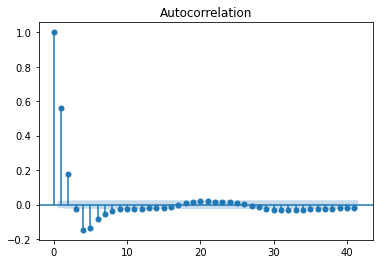

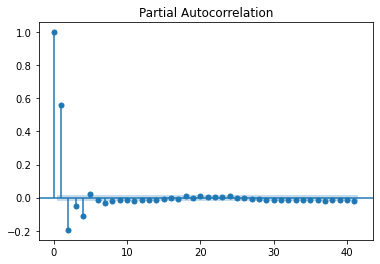

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

_ = plot_acf(diff)
_ = plot_pacf(diff)

### Compute the BIC

Calculate the BIC of the model with the `d`, `p`, and `q` you selected. Compare this to the BIC where you increase both `p` and `q` by 1. Use the BIC to determine the optimal model between these two. Use the model with the lowest BIC for the following parts.

> Choices for `q`: 1 - 2  
Choices for `p`: 2 - 4

In [8]:
from statsmodels.tsa.arima_model import ARIMA
import warnings

warnings.simplefilter('ignore') # get rid of warnings

d = 1

for p in [1, 2]:
    for q in [2, 3, 4]:
        model = ARIMA(past, order=(p, d, q))
        model_fit = model.fit(disp = 0)
        print('p = {}, d = {}, q = {}: BIC = {}'.format(p, d, q, model_fit.bic))

p = 1, d = 1, q = 2: BIC = -19244.77554010409
p = 1, d = 1, q = 3: BIC = -19236.951705997362
p = 1, d = 1, q = 4: BIC = -19256.227002599826
p = 2, d = 1, q = 2: BIC = -19306.653472671318
p = 2, d = 1, q = 3: BIC = -19300.49531216503
p = 2, d = 1, q = 4: BIC = -19299.306046990037


In [9]:
print('The optimal model: p = {}, d = {}, q = {}'.format(2, 1, 2))
model = ARIMA(past, order = (2, 1, 2))
model_fit = model.fit(disp = 0)
print('BIC = {}'.format(model_fit.bic))

print()

print('The model with p and q increased by 1: p = {}, d = {}, q = {}'.format(3, 1, 3))
subopt_model = ARIMA(past, order = (3, 1, 3))
subopt_model_fit = subopt_model.fit(disp = 0)
print('BIC = {}'.format(subopt_model_fit.bic))

The optimal model: p = 2, d = 1, q = 2
BIC = -19306.653472671318

The model with p and q increased by 1: p = 3, d = 1, q = 3
BIC = -19300.66189573888


**Plot the past data and the past prediction.**

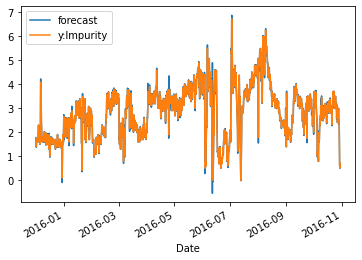

In [10]:
model_fit.plot_predict(dynamic = False)
plt.show()

**Plot the test data and the forecast along with 95% confidence bounds.**

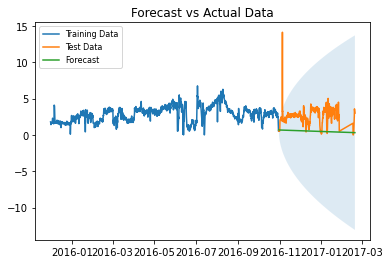

In [11]:
# Forecast
fc, se, conf = model_fit.forecast(N_test, alpha = 0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index = future.index)
lower_series = pd.Series(conf[:, 0], index = future.index)
upper_series = pd.Series(conf[:, 1], index = future.index)

# Plot
plt.plot(past, label = 'Training Data')
plt.plot(future, label = 'Test Data')
plt.plot(fc_series, label = 'Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, alpha=.15)
plt.title('Forecast vs Actual Data')
plt.legend(loc='upper left', fontsize = 8);